In [60]:
# Data Manipulation and Handling
import polars as pl
import pandas as pd
import numpy as np
import psycopg2

# DB Credentials
from dotenv import load_dotenv
import os
import sys
from sqlalchemy import create_engine

# Machine Learning Libraries
import torch
import xgboost as xgb
import lightgbm as lgb
# from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, chi2, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, accuracy_score, confusion_matrix, classification_report, roc_curve
import scipy.optimize as tnc
from sklearn.manifold import TSNE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Gradient Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model Lifecycle Management
import mlflow
import mlflow.sklearn

# Distributed Computing
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier as SparkRFClassifier

# Model Interpretability
import shap

# Hyperparameter Optimization
import optuna

# Automated Feature Engineering
import featuretools as ft

# Add parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Custom Modules
from fetch_data_hook import fetch_sql_code, fetch_sql_file

# ML Pipeline Flow

In [61]:
# 1. EDA Analysis
# 2. Feature Engineering
# 3. Train-Test Split
# 4. Feature Scaling: {normalization/standardization, dimension reduction techniques, handling imbalance datasets/sampling}
# 5. Model Training -> Tuning -> Evaluating
# 6. Model Prediction
# 7. Model Deployment

In [62]:
churn_df = fetch_sql_code('''
WITH temp1 AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp) AS rn,
        timestamp::date - ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp)::int AS streak_id
    FROM
        equity_value_data
),
temp2 AS (
    SELECT
        user_id,
        MIN(timestamp::date) AS start_streak_date,
        MAX(timestamp::date) AS end_streak_date,
        COUNT(*) AS duration_of_above10_streak
    FROM
        temp1
    GROUP BY
        user_id, streak_id
),
temp3 AS (
    SELECT
        *,
        LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS prev_above10_streak_date,
        start_streak_date - LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS duration_between_above10_streaks
    FROM
        temp2
)
SELECT distinct user_id
FROM temp3
WHERE duration_between_above10_streaks >= 28
''')
churn_df
churn_users = set(churn_df['user_id'].tolist())

df = fetch_sql_code('''
select * from features_data
''')

df['churn_flag'] = df['user_id'].apply(lambda x: 1 if x in churn_users else 0 )
df


,risk_tolerance,investment_experience,liquidity_needs,platform,time_spent,instrument_type_first_traded,first_deposit_amount,time_horizon,user_id,churn_flag
0,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,33.129417,stock,40.0,med_time_horizon,895044c23edc821881e87da749c01034,0
1,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,16.573517,stock,200.0,short_time_horizon,458b1d95441ced242949deefe8e4b638,0
2,med_risk_tolerance,limited_investment_exp,very_important_liq_need,iOS,10.008367,stock,25.0,long_time_horizon,c7936f653d293479e034865db9bb932f,0
3,med_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,1.031633,stock,100.0,short_time_horizon,b255d4bd6c9ba194d3a350b3e76c6393,0
4,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.187250,stock,20.0,long_time_horizon,4a168225e89375b8de605cbc0977ae91,0
...,...,...,...,...,...,...,...,...,...,...
5579,high_risk_tolerance,limited_investment_exp,very_important_liq_need,Android,8.339283,stock,300.0,long_time_horizon,03880c726d8a4e5db006afe4119ad974,0
5580,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,7.241383,stock,100.0,short_time_horizon,ae8315109657f44852b24c6bca4decd6,1
5581,med_risk_tolerance,no_investment_exp,very_important_liq_need,both,22.967167,stock,50.0,short_time_horizon,f29c174989f9737058fe808fcf264135,0
5582,med_risk_tolerance,limited_investment_exp,somewhat_important_liq_need,iOS,10.338417,stock,100.0,long_time_horizon,24843497d1de88b2e7233f694436cb3a,0


### Step 1: Data Preprocessing and Feature Engineering

In [63]:
# Prepare the data (Label Encoding + One-Hot Encoding + Scaling)
label_enc = LabelEncoder()
categorical_cols = ['risk_tolerance', 'investment_experience', 'liquidity_needs', 'platform', 'time_horizon']

for col in categorical_cols:
    df[col] = label_enc.fit_transform(df[col])

df = pd.get_dummies(df, columns=['instrument_type_first_traded'], drop_first=True)

numerical_cols = ['time_spent', 'first_deposit_amount']
df['deposit_per_time'] = df['first_deposit_amount'] / (df['time_spent'] + 1)
df['is_high_risk'] = (df['risk_tolerance'] == 0).astype(int)

X = df.drop(columns=['user_id', 'churn_flag'])
y = df['churn_flag']

# SMOTE for resampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

### Step 2: Model Definition and Objective Function for Optuna

In [64]:
def objective(trial):
    # **Step 1: Define the scaling options**
    scaler_options = {
        'standard': StandardScaler(),
        'minmax': MinMaxScaler(),
        'normalize': Normalizer(),
        'none': 'passthrough'  # Changed from None to 'none' for clarity
    }
    scaler = scaler_options[trial.suggest_categorical('scaler', ['standard', 'minmax', 'normalize', 'none'])]

    # **Step 2: Define feature selection options**
    feature_selection_type = trial.suggest_categorical('feature_selection', ['generic_univariate', 'rfe', 'none'])

    if feature_selection_type == 'generic_univariate':
        percentile = trial.suggest_int('percentile', 10, 50)
        feature_selector = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=percentile)
        # Estimate max possible features after selection
        pca_max = max(1, int(np.ceil(19 * percentile / 100)))  # Assuming 19 features initially
    elif feature_selection_type == 'rfe':
        n_features_to_select = trial.suggest_int('n_features_to_select', 5, 20)
        feature_selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=n_features_to_select)
        pca_max = n_features_to_select
    else:
        feature_selector = 'passthrough'
        pca_max = 19  # Original number of features

    # **Step 3: Define dimensionality reduction options**
    dim_reduction_type = trial.suggest_categorical('dim_reduction', ['pca', 'none'])

    if dim_reduction_type == 'pca':
        # Ensure pca_n_components does not exceed pca_max
        pca_n_components = trial.suggest_int('pca_n_components', 1, min(30, pca_max))
        dim_reduction = PCA(n_components=pca_n_components)
    else:
        dim_reduction = 'passthrough'

    # **Step 4: Define sampling options**
    sampling_type = trial.suggest_categorical('sampling', ['smote', 'random_oversampling', 'random_undersampling', 'none'])

    if sampling_type == 'smote':
        sampler = SMOTE(random_state=42)
    elif sampling_type == 'random_oversampling':
        sampler = RandomOverSampler(random_state=42)
    elif sampling_type == 'random_undersampling':
        sampler = RandomUnderSampler(random_state=42)
    else:
        sampler = 'passthrough'

    # **Step 5: Define model options**
    model_type = trial.suggest_categorical('model_type', ['xgboost', 'lightgbm', 'randomforest', 'logistic'])

    if model_type == 'xgboost':
        model = xgb.XGBClassifier(
            max_depth=trial.suggest_int('xgb_max_depth', 3, 10),
            learning_rate=trial.suggest_float('xgb_learning_rate', 0.01, 0.3, log=True),
            n_estimators=trial.suggest_int('xgb_n_estimators', 50, 300),
            subsample=trial.suggest_float('xgb_subsample', 0.6, 1.0),
            use_label_encoder=False,
            eval_metric='logloss'
        )
    elif model_type == 'lightgbm':
        model = lgb.LGBMClassifier(
            num_leaves=trial.suggest_int('lgb_num_leaves', 20, 150),
            learning_rate=trial.suggest_float('lgb_learning_rate', 0.01, 0.3, log=True),
            n_estimators=trial.suggest_int('lgb_n_estimators', 50, 300),
            feature_fraction=trial.suggest_float('lgb_feature_fraction', 0.6, 1.0)
        )
    elif model_type == 'randomforest':
        max_features = trial.suggest_categorical('rf_max_features', ['sqrt', 'log2', 'None'])
        model = RandomForestClassifier(
            max_depth=trial.suggest_int('rf_max_depth', 3, 10),
            n_estimators=trial.suggest_int('rf_n_estimators', 50, 300),
            max_features=None if max_features == 'None' else max_features,
            random_state=42
        )
    else:  # Logistic Regression
        penalty = trial.suggest_categorical('lr_penalty', ['l1', 'l2'])
        model = LogisticRegression(
            penalty=penalty,
            C=trial.suggest_float('lr_C', 0.01, 10, log=True),
            solver='liblinear'
        )

    # **Step 6: Build the pipeline using imblearn's Pipeline**
    pipeline = ImbPipeline([
        ('scaler', scaler),
        ('feature_selector', feature_selector),
        ('dim_reduction', dim_reduction),
        ('sampler', sampler),
        ('model', model)
    ])

    # **Step 7: Cross-validation**
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = []

    for train_idx, test_idx in kfold.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[test_idx]

        try:
            # Fit the pipeline on training data
            pipeline.fit(X_train, y_train)

            # Predict probabilities on validation data
            y_pred_proba = pipeline.predict_proba(X_valid)[:, 1]

            # Calculate ROC AUC
            roc_auc = roc_auc_score(y_valid, y_pred_proba)
            roc_auc_scores.append(roc_auc)
        except Exception as e:
            # If any error occurs during fitting/prediction, skip this trial
            return 0.0  # Assign a poor score to this trial

    # Return the average ROC AUC score
    return np.mean(roc_auc_scores)

### Step 3: Running Optuna for Hyperparameter Tuning

In [65]:
# Run Optuna for hyperparameter tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=10) #n_trials=100)

# Print the best trial and parameters
print(f"Best Trial: {study.best_trial}")
print(f"Best Parameters: {study.best_params}")

[I 2024-10-03 22:08:23,958] A new study created in memory with name: no-name-d03203d4-0ea9-45bb-9fa5-6694ffa63d2d


[LightGBM] [Warning] feature_fraction is set=0.8297544015370377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8297544015370377
[LightGBM] [Warning] feature_fraction is set=0.8297544015370377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8297544015370377
[LightGBM] [Info] Number of positive: 4244, number of negative: 4244
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 8488, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] feature_fraction is set=0.8297544015370377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8297544015370377
[LightGBM] [Warning] feature_fraction 

[I 2024-10-03 22:08:25,714] Trial 0 finished with value: 0.549153732695203 and parameters: {'scaler': 'none', 'feature_selection': 'none', 'dim_reduction': 'pca', 'pca_n_components': 18, 'sampling': 'random_oversampling', 'model_type': 'lightgbm', 'lgb_num_leaves': 73, 'lgb_learning_rate': 0.1572502505002514, 'lgb_n_estimators': 139, 'lgb_feature_fraction': 0.8297544015370377}. Best is trial 0 with value: 0.549153732695203.


[LightGBM] [Warning] feature_fraction is set=0.8297544015370377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8297544015370377
[LightGBM] [Warning] feature_fraction is set=0.8901547554002815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8901547554002815
[LightGBM] [Warning] feature_fraction is set=0.8901547554002815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8901547554002815
[LightGBM] [Info] Number of positive: 4244, number of negative: 4244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 8488, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] feature_fraction is set=0.8901547554002815, colsample_bytree=1.0 will be ignored. C

[I 2024-10-03 22:08:26,927] Trial 1 finished with value: 0.5486259593375522 and parameters: {'scaler': 'none', 'feature_selection': 'none', 'dim_reduction': 'pca', 'pca_n_components': 3, 'sampling': 'smote', 'model_type': 'lightgbm', 'lgb_num_leaves': 85, 'lgb_learning_rate': 0.04384776356396758, 'lgb_n_estimators': 131, 'lgb_feature_fraction': 0.8901547554002815}. Best is trial 0 with value: 0.549153732695203.


[LightGBM] [Warning] feature_fraction is set=0.8901547554002815, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8901547554002815


[I 2024-10-03 22:08:28,522] Trial 2 finished with value: 0.6134830532332889 and parameters: {'scaler': 'normalize', 'feature_selection': 'generic_univariate', 'percentile': 26, 'dim_reduction': 'pca', 'pca_n_components': 5, 'sampling': 'smote', 'model_type': 'logistic', 'lr_penalty': 'l1', 'lr_C': 0.9863462196959508}. Best is trial 2 with value: 0.6134830532332889.
[I 2024-10-03 22:08:30,111] Trial 3 finished with value: 0.5478979950304173 and parameters: {'scaler': 'none', 'feature_selection': 'generic_univariate', 'percentile': 44, 'dim_reduction': 'pca', 'pca_n_components': 6, 'sampling': 'none', 'model_type': 'logistic', 'lr_penalty': 'l1', 'lr_C': 0.011662759444010327}. Best is trial 2 with value: 0.6134830532332889.
[I 2024-10-03 22:08:31,732] Trial 4 finished with value: 0.6197073637954883 and parameters: {'scaler': 'normalize', 'feature_selection': 'generic_univariate', 'percentile': 30, 'dim_reduction': 'none', 'sampling': 'random_oversampling', 'model_type': 'logistic', 'lr_p

[LightGBM] [Warning] feature_fraction is set=0.9348046358270813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9348046358270813
[LightGBM] [Warning] feature_fraction is set=0.9348046358270813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9348046358270813
[LightGBM] [Info] Number of positive: 223, number of negative: 4244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 4467, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049922 -> initscore=-2.946090
[LightGBM] [Info] Start training from score -2.946090
[LightGBM] [Warning] feature_fraction is set=0.9348046358270813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9348046358270813
[LightGBM] [Warning] feature_fraction is set=0.9

[I 2024-10-03 22:08:32,965] Trial 5 finished with value: 0.5525291320366721 and parameters: {'scaler': 'standard', 'feature_selection': 'none', 'dim_reduction': 'pca', 'pca_n_components': 10, 'sampling': 'none', 'model_type': 'lightgbm', 'lgb_num_leaves': 33, 'lgb_learning_rate': 0.18243988784703816, 'lgb_n_estimators': 275, 'lgb_feature_fraction': 0.9348046358270813}. Best is trial 4 with value: 0.6197073637954883.


[LightGBM] [Warning] feature_fraction is set=0.9348046358270813, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9348046358270813


[I 2024-10-03 22:08:34,539] Trial 6 finished with value: 0.5967663745302765 and parameters: {'scaler': 'standard', 'feature_selection': 'generic_univariate', 'percentile': 18, 'dim_reduction': 'none', 'sampling': 'none', 'model_type': 'logistic', 'lr_penalty': 'l1', 'lr_C': 2.8085269043726355}. Best is trial 4 with value: 0.6197073637954883.


[LightGBM] [Warning] feature_fraction is set=0.8303268553927818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8303268553927818
[LightGBM] [Warning] feature_fraction is set=0.8303268553927818, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8303268553927818
[LightGBM] [Info] Number of positive: 223, number of negative: 4244
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 4467, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049922 -> initscore=-2.946090
[LightGBM] [Info] Start training from score -2.946090
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.8303268553927818, colsample_bytree=1.0 will be ignored. Current value: feature_fra

[I 2024-10-03 22:09:22,967] Trial 7 finished with value: 0.5384078056721788 and parameters: {'scaler': 'none', 'feature_selection': 'rfe', 'n_features_to_select': 6, 'dim_reduction': 'none', 'sampling': 'none', 'model_type': 'lightgbm', 'lgb_num_leaves': 149, 'lgb_learning_rate': 0.033099616355943155, 'lgb_n_estimators': 80, 'lgb_feature_fraction': 0.8303268553927818}. Best is trial 4 with value: 0.6197073637954883.
[I 2024-10-03 22:09:46,770] Trial 8 finished with value: 0.6156823689976376 and parameters: {'scaler': 'none', 'feature_selection': 'rfe', 'n_features_to_select': 13, 'dim_reduction': 'none', 'sampling': 'none', 'model_type': 'randomforest', 'rf_max_features': 'log2', 'rf_max_depth': 6, 'rf_n_estimators': 117}. Best is trial 4 with value: 0.6197073637954883.
[I 2024-10-03 22:09:49,071] Trial 9 finished with value: 0.553472098118658 and parameters: {'scaler': 'minmax', 'feature_selection': 'generic_univariate', 'percentile': 44, 'dim_reduction': 'none', 'sampling': 'random_u

Best Trial: FrozenTrial(number=4, state=TrialState.COMPLETE, values=[0.6197073637954883], datetime_start=datetime.datetime(2024, 10, 3, 22, 8, 30, 112472), datetime_complete=datetime.datetime(2024, 10, 3, 22, 8, 31, 732835), params={'scaler': 'normalize', 'feature_selection': 'generic_univariate', 'percentile': 30, 'dim_reduction': 'none', 'sampling': 'random_oversampling', 'model_type': 'logistic', 'lr_penalty': 'l2', 'lr_C': 0.42130745395499314}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'scaler': CategoricalDistribution(choices=('standard', 'minmax', 'normalize', 'none')), 'feature_selection': CategoricalDistribution(choices=('generic_univariate', 'rfe', 'none')), 'percentile': IntDistribution(high=50, log=False, low=10, step=1), 'dim_reduction': CategoricalDistribution(choices=('pca', 'none')), 'sampling': CategoricalDistribution(choices=('smote', 'random_oversampling', 'random_undersampling', 'none')), 'model_type': CategoricalDistribution(choices=('xg

### Step 4: Final Model Selection and Evaluation

In [66]:
# Extract the best parameters from the Optuna study
best_params = study.best_params

# Define the components of the pipeline based on the best parameters
pipeline_steps = []

# Step 1: Add the scaler based on best_params
scaler_options = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'normalize': Normalizer(),
    None: 'passthrough'
}
pipeline_steps.append(('scaler', scaler_options[best_params['scaler']]))

# Step 2: Add feature selection based on best_params
feature_selection_options = {
    'generic_univariate': GenericUnivariateSelect(
        score_func=mutual_info_classif,
        mode='percentile',
        param=best_params.get('percentile', 10)  # Default to 10 if 'percentile' is missing
    ),
    'rfe': RFE(
        estimator=RandomForestClassifier(),
        n_features_to_select=best_params.get('n_features_to_select', 5)  # Default to 5 if 'n_features_to_select' is missing
    ),
    None: 'passthrough'
}
pipeline_steps.append(('feature_selector', feature_selection_options[best_params['feature_selection']]))

# Step 3: Add PCA or passthrough for dimensionality reduction
def dynamic_pca_components(X):
    return min(best_params.get('pca_n_components', 1), X.shape[1])  # Default to 1 component if missing

# Adjust the PCA step to account for X_resampled shape at runtime
if best_params['dim_reduction'] == 'pca':
    pipeline_steps.append(('dim_reduction', PCA(n_components=dynamic_pca_components(X_resampled))))
else:
    pipeline_steps.append(('dim_reduction', 'passthrough'))

# Step 4: Add model based on the best model_type
if best_params['model_type'] == 'xgboost':
    best_model = xgb.XGBClassifier(
        max_depth=best_params['max_depth'],
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        subsample=best_params['subsample']
    )
elif best_params['model_type'] == 'lightgbm':
    best_model = lgb.LGBMClassifier(
        num_leaves=best_params['num_leaves'],
        learning_rate=best_params['learning_rate'],
        n_estimators=best_params['n_estimators'],
        feature_fraction=best_params['feature_fraction']
    )
elif best_params['model_type'] == 'randomforest':
    best_model = RandomForestClassifier(
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        max_features=best_params['max_features']
    )
else:
    # Use .get() with default values to avoid KeyError
    best_model = LogisticRegression(
        penalty=best_params.get('penalty', 'l2'),  # Default to 'l2' penalty if not found
        C=best_params.get('C', 1.0),  # Default to C=1.0 if not found
        solver=best_params.get('solver', 'liblinear')  # Default to 'liblinear' solver if not found
    )

# Add the model to the pipeline
pipeline_steps.append(('model', best_model))

# Build the final pipeline
pipeline = Pipeline(pipeline_steps)

# Train the pipeline on the resampled data
pipeline.fit(X_resampled, y_resampled)

# Step 5: Evaluate the pipeline on the original (non-resampled) data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Predict on the test set
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

# Step 6: Final model performance evaluation
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Step 7: Output the results
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print final results
print(f'Final Model Accuracy: {accuracy}')
print(f'Final Model ROC AUC: {roc_auc}')
print(f'Final Model Precision-Recall AUC: {pr_auc}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')


Final Model Accuracy: 0.8210023866348448
Final Model ROC AUC: 0.6227717731829575
Final Model Precision-Recall AUC: 0.08000614918066302
Confusion Matrix:
[[1351  245]
 [  55   25]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1596
           1       0.09      0.31      0.14        80

    accuracy                           0.82      1676
   macro avg       0.53      0.58      0.52      1676
weighted avg       0.92      0.82      0.86      1676



### Step 5: Model Explainability with SHAP

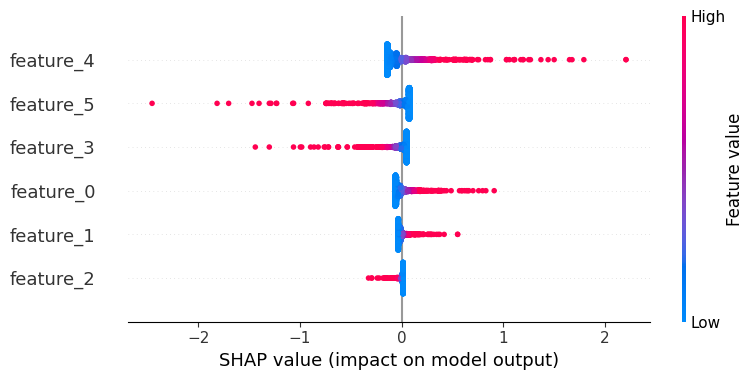

In [75]:
# Check if the best_model is tree-based
if isinstance(best_model, (RandomForestClassifier, XGBClassifier, LGBMClassifier)):
    # SHAP for tree-based models
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(pipeline[:-1].transform(X_test))  # Apply all transformations except the model
    shap.summary_plot(shap_values, pipeline[:-1].transform(X_test), feature_names=X.columns)

elif isinstance(best_model, LogisticRegression):
    # Apply all transformations except the model to X_test
    X_test_transformed = pipeline[:-1].transform(X_test)

    # Get the feature names after transformations (if available)
    transformed_feature_names = X_test_transformed.columns if hasattr(X_test_transformed, 'columns') else [f'feature_{i}' for i in range(X_test_transformed.shape[1])]

    # SHAP for logistic regression using transformed data
    explainer = shap.Explainer(best_model, X_test_transformed)

    # Calculate SHAP values
    shap_values = explainer(X_test_transformed)

    # SHAP Summary Plot with the correct feature names
    shap.summary_plot(shap_values, X_test_transformed, feature_names=transformed_feature_names)

else:
    print("Model type not supported for SHAP explainer")


# # SHAP for feature importance
# explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(X_test)

# # SHAP Summary Plot
# shap.summary_plot(shap_values, X_test, feature_names=X.columns)


## EDA

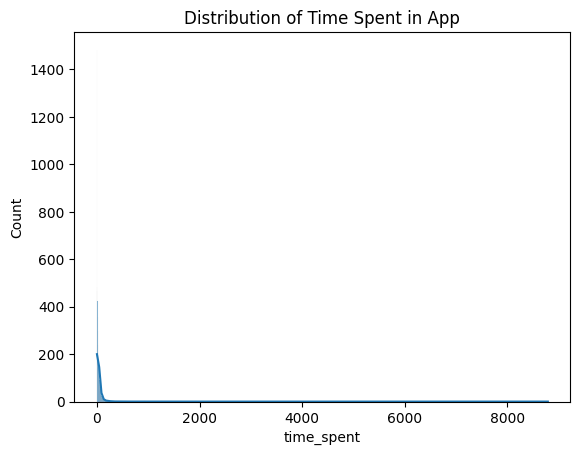

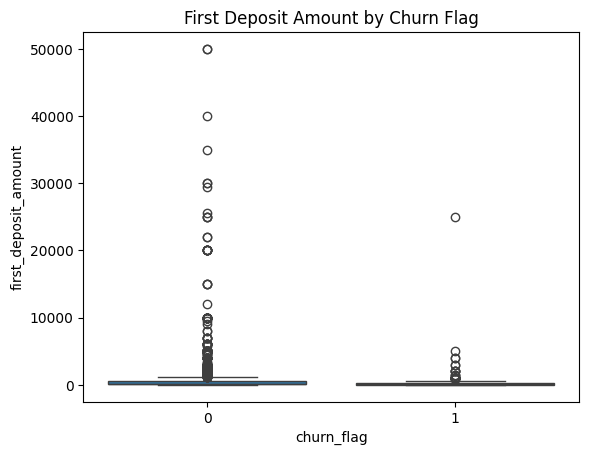

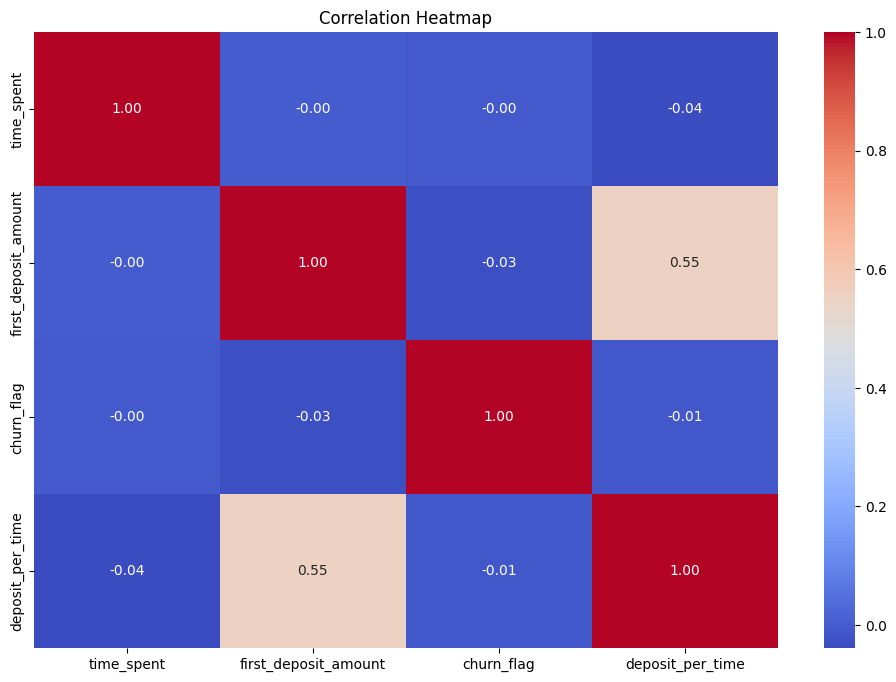

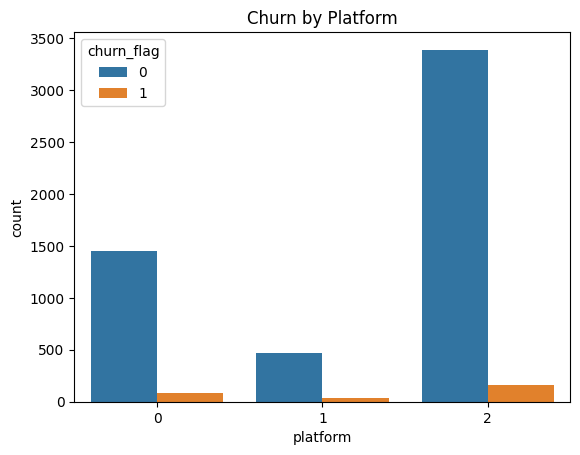

In [76]:
# Distribution of time spent in app
sns.histplot(df['time_spent'], kde=True)
plt.title('Distribution of Time Spent in App')
plt.show()

# Boxplot of first deposit amount by churn flag
sns.boxplot(x='churn_flag', y='first_deposit_amount', data=df)
plt.title('First Deposit Amount by Churn Flag')
plt.show()

# Select only the numerical columns from the DataFrame
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Create the heatmap using the correlation matrix of the numerical columns
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Countplot for churn by platform for categorical features
sns.countplot(x='platform', hue='churn_flag', data=df)
plt.title('Churn by Platform')
plt.show()


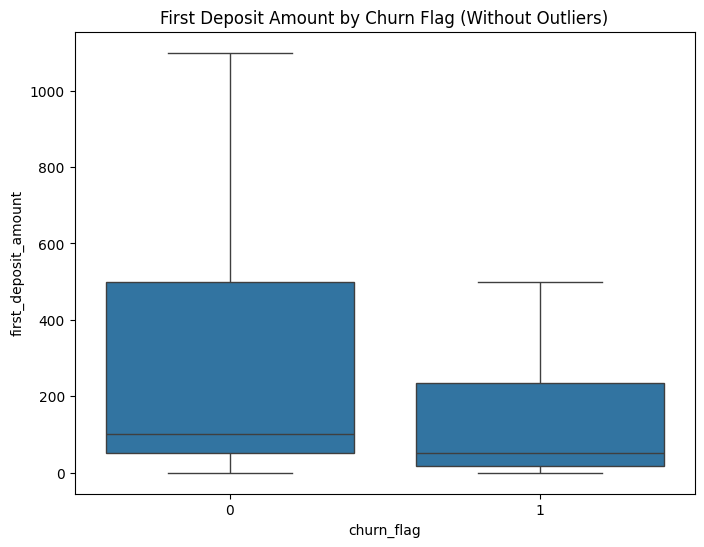

In [77]:
plt.figure(figsize=(8, 6))  # Adjust the figure size
sns.boxplot(x='churn_flag', y='first_deposit_amount', data=df, showfliers=False)
plt.title('First Deposit Amount by Churn Flag (Without Outliers)')
plt.show()


# ENHACEMENTS:

In [78]:
'''
1. Advanced Resampling Techniques:
SMOTE Variants: Beyond traditional SMOTE, there are more advanced variants like SMOTE-NC (for categorical variables) or SMOTE-Tomek Links (combining oversampling with undersampling to remove noise).
ADASYN (Adaptive Synthetic Sampling): This method adapts SMOTE by focusing on more difficult-to-classify examples, potentially yielding better performance on harder cases in the minority class.
NearMiss: This is an undersampling method that selects negative examples near the decision boundary, making the classifier more sensitive to difficult minority examples.
2. Ensemble Learning:
Balanced Random Forests: Modify the random forest algorithm to draw balanced bootstrap samples (oversampling the minority class or undersampling the majority class at each tree).
EasyEnsemble and BalanceCascade: These are ensemble methods designed for imbalanced datasets. EasyEnsemble combines random undersampling with boosting to create a more robust model.
XGBoost with Imbalanced Data: XGBoost has built-in support for handling imbalanced data via the scale_pos_weight parameter. Setting it to the inverse ratio of class distribution helps the model learn the minority class better.
3. Class Weighting:
Instead of resampling, many models like XGBoost, LightGBM, RandomForest, and Logistic Regression support setting class weights to address class imbalance. By assigning higher weights to the minority class, you can penalize the model more for misclassifying minority samples.
Example: In XGBoost, use scale_pos_weight, and in RandomForestClassifier, use the class_weight='balanced' parameter.
4. Threshold Tuning:
The default decision threshold of 0.5 for classification models is often suboptimal for imbalanced datasets. Tuning the decision threshold can significantly improve performance, especially for metrics like precision, recall, and F1-score.
You can experiment with threshold-moving techniques to balance precision and recall better based on the model’s predicted probabilities.
5. Focal Loss:
Focal Loss is a modification of the cross-entropy loss that puts more focus on hard-to-classify examples, making it well-suited for imbalanced classification. This is widely used in deep learning models but can also be implemented in gradient boosting libraries.
Example: Focal Loss is supported in LightGBM and TensorFlow/Keras for imbalanced data.
6. Anomaly Detection Algorithms:
Since churn is often rare, you could treat it as an anomaly detection problem. Algorithms like Isolation Forest, One-Class SVM, or AutoEncoders can be repurposed for identifying rare events, such as churn, by flagging unusual behavior.
7. Stacking and Blending:
Stacking and Blending are ensemble techniques where multiple models are combined to improve performance. For imbalanced datasets, a combination of different classifiers (e.g., RandomForest, XGBoost, LightGBM) with different resampling techniques (SMOTE for some, class weighting for others) can produce better results.
You can also consider blending models that perform well on different metrics (e.g., one model optimized for precision, another for recall) to create a more robust classifier.
8. Feature Engineering Specific to Churn:
Behavioral Features: Focus on creating time-based features that capture user behavior over time. For example, features like time since last transaction, recency, frequency, and monetary value (RFM analysis) can be useful for identifying churn patterns.
Interaction Features: Combinations of existing features (e.g., deposit amount per time spent) can capture complex relationships that models may not easily detect.
Lag Features: Incorporate lag features or rolling windows to track user behavior over time (e.g., average time spent in the last 3 months, frequency of visits in the last 30 days).
9. Cost-Sensitive Learning:
In cost-sensitive learning, you explicitly define the cost of misclassification. For churn datasets, you can set a higher cost for misclassifying churners (false negatives) to emphasize reducing churn prediction errors.
You can implement custom loss functions or weight misclassification errors according to business impact (e.g., churn has a higher cost than non-churn).
10. Bayesian Optimization for Hyperparameter Tuning:
Optuna is great, but you can take hyperparameter tuning a step further with Bayesian Optimization. Libraries like Hyperopt and BayesianOptimization can help fine-tune hyperparameters in a more data-efficient manner, often converging faster and leading to better models.
11. Explainability Tools:
SHAP (SHapley Additive exPlanations) and LIME (Local Interpretable Model-agnostic Explanations): Use these tools to explain model predictions, especially for imbalanced data. These techniques can help identify why the model misclassifies minority class instances, leading to insights into feature engineering or model tuning.
12. Time-Series Modeling (if relevant):
If your churn data is time-dependent, consider using time-series classification models like Prophet, LSTM, or GRU. These models can capture temporal trends and patterns that might be critical for predicting churn.
13. Active Learning:
In cases where obtaining labeled data is expensive, active learning can be used to focus on annotating the most informative instances (e.g., uncertain predictions). This can help when labeled data for churn is sparse, improving model performance without needing massive amounts of data.
14. Custom Evaluation Metrics:
Use domain-specific metrics that reflect the business cost of churn (e.g., focus on high-recall models if missing a churner is more expensive). Additionally, consider profit-based metrics or a custom metric like a "churn score" that integrates recall and business costs.
Conclusion:
For a churn prediction task with imbalanced data, combining resampling techniques, ensemble learning, precision-recall optimization, class weighting, and advanced feature engineering is key. Incorporating modern methods like focal loss, Bayesian optimization, and explainability tools like SHAP can significantly boost model performance and interpretability.
'''

'\n1. Advanced Resampling Techniques:\nSMOTE Variants: Beyond traditional SMOTE, there are more advanced variants like SMOTE-NC (for categorical variables) or SMOTE-Tomek Links (combining oversampling with undersampling to remove noise).\nADASYN (Adaptive Synthetic Sampling): This method adapts SMOTE by focusing on more difficult-to-classify examples, potentially yielding better performance on harder cases in the minority class.\nNearMiss: This is an undersampling method that selects negative examples near the decision boundary, making the classifier more sensitive to difficult minority examples.\n2. Ensemble Learning:\nBalanced Random Forests: Modify the random forest algorithm to draw balanced bootstrap samples (oversampling the minority class or undersampling the majority class at each tree).\nEasyEnsemble and BalanceCascade: These are ensemble methods designed for imbalanced datasets. EasyEnsemble combines random undersampling with boosting to create a more robust model.\nXGBoost w